In [1]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Add project root to path
sys.path.append(os.path.abspath('..'))

from src.data_loader import DataLoader
from src.validators import (
    PriceValidator,
    CalculationValidator,
    ReconciliationValidator,
    ConsistencyValidator,
    DataCompletenessValidator,
    FXConsistencyValidator,
    StaticDataValidator
)

# Setup plotting
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Load Data
data_path = '../data/Test.csv'
loader = DataLoader(data_path)
positions, trades = loader.load_data()

print(f"Loaded {len(positions)} positions and {len(trades)} trades.")
print(f"Date Range: {positions['Date'].min()} to {positions['Date'].max()}")

Loaded 7721 positions and 468 trades.
Date Range: 2022-01-03 00:00:00 to 2022-12-29 00:00:00


## 1. Price Validation
We detect unrealistic price jumps using Z-Scores. A high Z-Score indicates a price movement that is statistically unlikely compared to the asset's recent volatility.

Found 3 price errors.


,date,ticker,error_type,description,severity
0,2022-12-07,CVNA,Price Spike,"Price spike detected: 3.83 (Prev: 6.71, Next: ...",High
1,2022-09-06,HSBK,Price Spike,"Price spike detected: 9.65 (Prev: 10.76, Next:...",Medium
2,2022-11-03,MBTN,Price Spike,"Price spike detected: 0.46 (Prev: 0.4, Next: 0...",Medium


Visualizing Price History for: CVNA


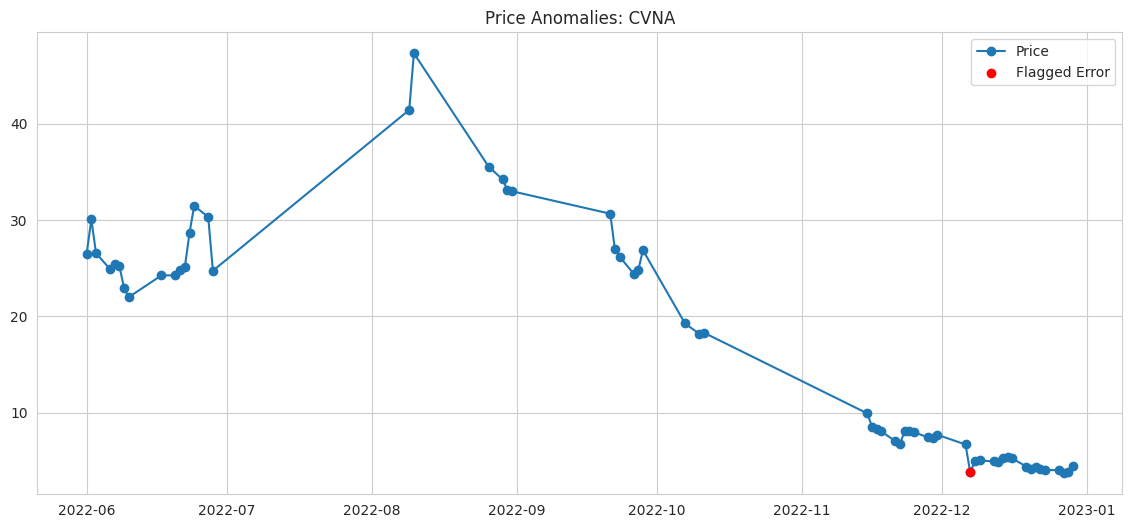

In [2]:
validator = PriceValidator(positions, trades)
price_errors = validator.validate()

print(f"Found {len(price_errors)} price errors.")
if price_errors:
    price_errors_df = pd.DataFrame([vars(e) for e in price_errors])
    display(price_errors_df.sort_values('severity').head())
    
    # Visualize Top Offender
    top_ticker = price_errors_df['ticker'].mode()[0]
    print(f"Visualizing Price History for: {top_ticker}")
    
    subset = positions[positions['P_Ticker'] == top_ticker].sort_values('Date')
    subset['Price'] = pd.to_numeric(subset['Price'], errors='coerce')
    
    plt.figure(figsize=(14, 6))
    plt.plot(subset['Date'], subset['Price'], marker='o', label='Price')
    
    # Mark errors
    err_dates = price_errors_df[price_errors_df['ticker'] == top_ticker]['date']
    plt.scatter(err_dates, subset[subset['Date'].isin(err_dates)]['Price'], color='red', label='Flagged Error', zorder=5)
    
    plt.title(f"Price Anomalies: {top_ticker}")
    plt.legend()
    plt.show()
else:
    price_errors_df = pd.DataFrame()

## 2. Reconciliation Validation
We verify that the change in position quantity matches the trades executed.
`Qty(T) = Qty(T-1) + Buy - Sell`

Found 19 reconciliation errors.


/tmp/ipykernel_213209/2032818676.py:83: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=severity_counts.index, y=severity_counts.values, palette='viridis', ax=ax2)


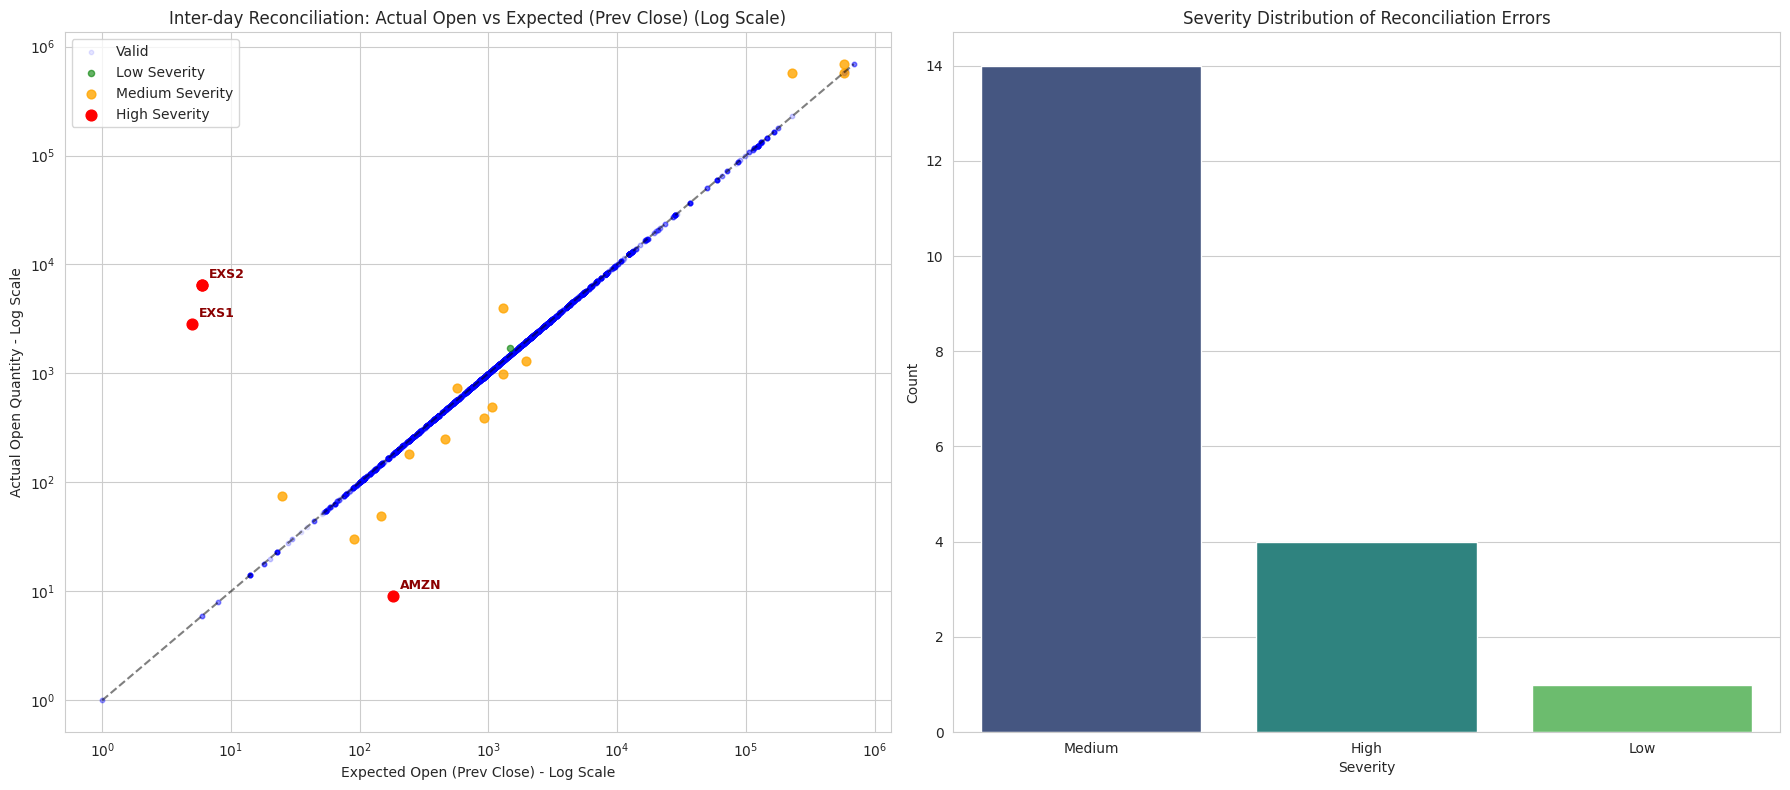

,date,ticker,error_type,description,severity
0,2022-08-23,AMC,Reconciliation Error (Inter-day),Inter-day Mismatch: Open -983.00 != Prev Close...,Medium
1,2022-08-24,AMC,Reconciliation Error (Inter-day),Inter-day Mismatch: Open -1310.00 != Prev Clos...,Medium
2,2022-05-12,AMZN,Reconciliation Error (Inter-day),Inter-day Mismatch: Open -251.00 != Prev Close...,Medium
3,2022-05-19,AMZN,Reconciliation Error (Inter-day),Inter-day Mismatch: Open -183.00 != Prev Close...,Medium
4,2022-05-20,AMZN,Reconciliation Error (Inter-day),Inter-day Mismatch: Open -9.00 != Prev Close -...,High
5,2022-06-23,CORN,Reconciliation Error (Inter-day),Inter-day Mismatch: Open -4000.00 != Prev Clos...,Medium
6,2022-08-03,EXS1,Reconciliation Error (Inter-day),Inter-day Mismatch: Open -2825.00 != Prev Clos...,High
7,2022-11-07,EXS2,Reconciliation Error (Inter-day),Inter-day Mismatch: Open -6450.00 != Prev Clos...,High
8,2022-11-28,EXS2,Reconciliation Error (Inter-day),Inter-day Mismatch: Open 6450.00 != Prev Close...,High
9,2022-10-11,QQQ,Reconciliation Error (Inter-day),Inter-day Mismatch: Open -1722.00 != Prev Clos...,Low


Visualizing top 3 tickers with High Severity Inter-day errors.
Visualizing Inter-day errors for: EXS2 (Count: 2)


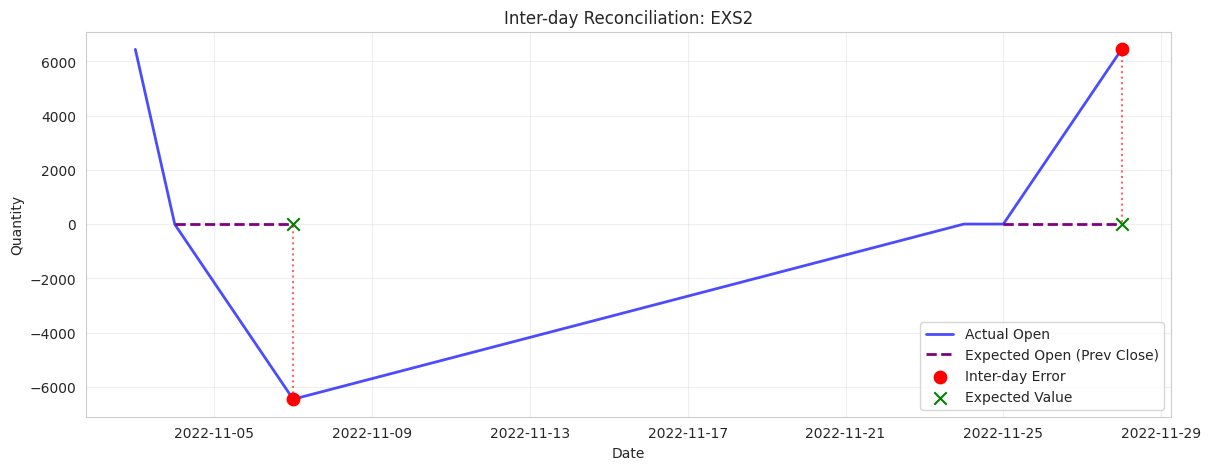

Visualizing Inter-day errors for: AMZN (Count: 1)


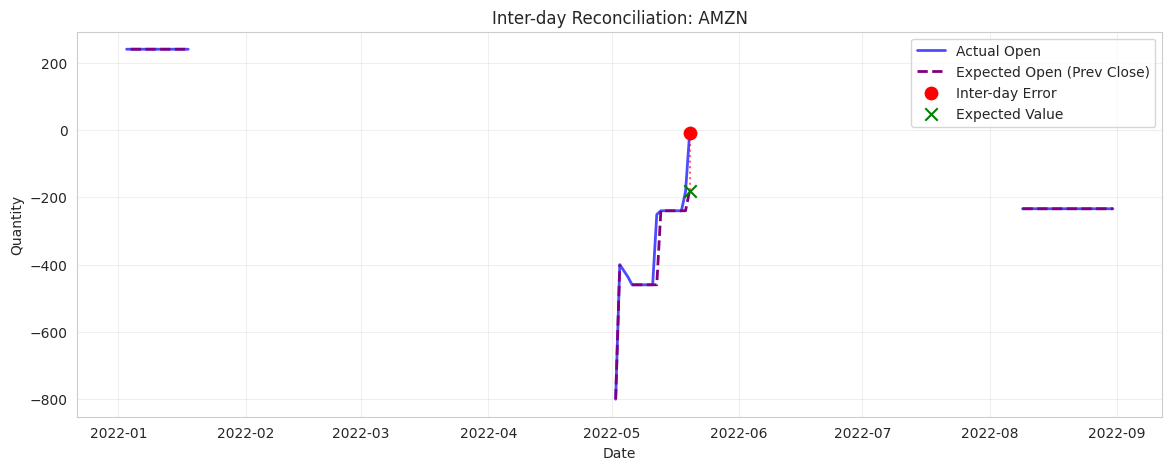

Visualizing Inter-day errors for: EXS1 (Count: 1)


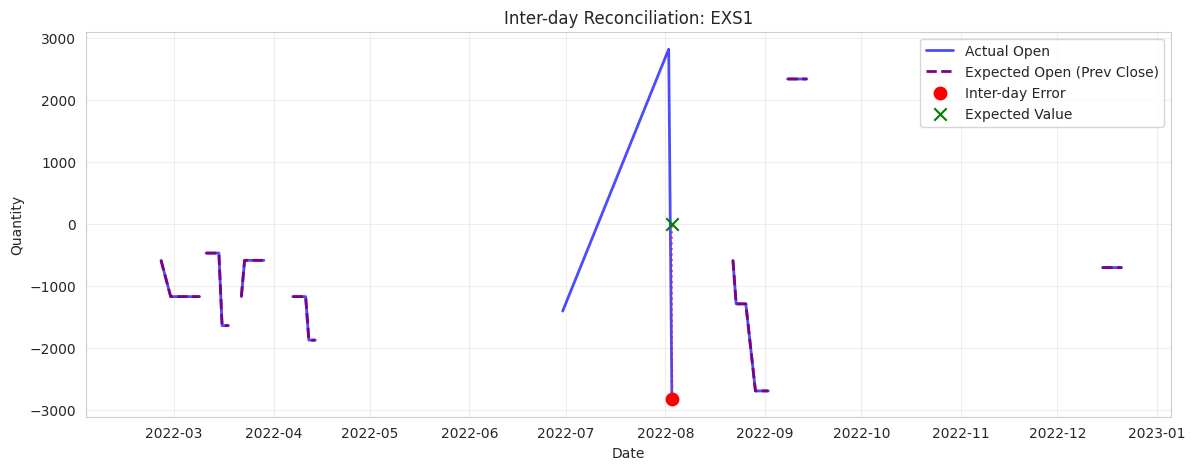

In [3]:
validator = ReconciliationValidator(positions, trades)
reconciliation_errors = validator.validate()

print(f"Found {len(reconciliation_errors)} reconciliation errors.")
if reconciliation_errors:
    reconciliation_errors_df = pd.DataFrame([vars(e) for e in reconciliation_errors])
    
    # --- Visualization 1: Inter-day Discrepancies (Log-Log Plot) & Severity ---
    
    # Filter for Inter-day errors
    inter_errors = [e for e in reconciliation_errors if "Inter-day" in e.error_type]
    
    if inter_errors:
        fig, axes = plt.subplots(1, 2, figsize=(18, 8))
        ax1 = axes[0]
        ax2 = axes[1]
        
        # Prepare data for plotting
        df = positions.copy()
        cols = ["Close Quantity", "Open Quantity"]
        for col in cols:
            df[col] = pd.to_numeric(df[col], errors='coerce')
            
        # Sort to get Prev Close
        df = df.sort_values(by=["P_Ticker", "Date"])
        df["Prev_Close"] = df.groupby("P_Ticker")["Close Quantity"].shift(1)
        
        # Identify error rows
        error_keys = set((e.date, e.ticker) for e in inter_errors)
        severity_map = {(e.date, e.ticker): e.severity for e in inter_errors}
        
        df['Is_Error'] = df.apply(lambda row: (row['Date'], row['P_Ticker']) in error_keys, axis=1)
        df['Severity'] = df.apply(lambda row: severity_map.get((row['Date'], row['P_Ticker']), 'None'), axis=1)
        
        # 1. Plot "Valid" points
        valid_data = df[~df['Is_Error'] & df['Open Quantity'].notna() & df['Prev_Close'].notna()]
        ax1.scatter(valid_data["Prev_Close"].abs(), valid_data["Open Quantity"].abs(), 
                    alpha=0.1, c='blue', label='Valid', s=10)
        
        # 2. Plot Errors by Severity
        high = df[df['Severity'] == 'High']
        med = df[df['Severity'] == 'Medium']
        low = df[df['Severity'] == 'Low']
        
        if not low.empty:
            ax1.scatter(low["Prev_Close"].abs(), low["Open Quantity"].abs(), c='green', label='Low Severity', s=20, alpha=0.6)
        if not med.empty:
            ax1.scatter(med["Prev_Close"].abs(), med["Open Quantity"].abs(), c='orange', label='Medium Severity', s=40, alpha=0.8)
        if not high.empty:
            ax1.scatter(high["Prev_Close"].abs(), high["Open Quantity"].abs(), c='red', label='High Severity', s=60, alpha=1.0)
        
        # Annotate High Severity Errors
        annotated_tickers = set()
        for idx, row in high.iterrows():
            if row['P_Ticker'] not in annotated_tickers:
                ax1.annotate(f"{row['P_Ticker']}", 
                             (abs(row['Prev_Close']), abs(row['Open Quantity'])),
                             xytext=(5, 5), textcoords='offset points',
                             fontsize=9, color='darkred', fontweight='bold')
                annotated_tickers.add(row['P_Ticker'])
                if len(annotated_tickers) >= 10: break

        # Diagonal line
        max_val = max(df["Prev_Close"].abs().max(), df["Open Quantity"].abs().max())
        if pd.isna(max_val): max_val = 1
        
        min_val = min(df[df["Prev_Close"].abs() > 0]["Prev_Close"].abs().min(), 
                      df[df["Open Quantity"].abs() > 0]["Open Quantity"].abs().min())
        if pd.isna(min_val) or min_val == 0: min_val = 0.01
        
        ax1.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5)
        
        ax1.set_title("Inter-day Reconciliation: Actual Open vs Expected (Prev Close) (Log Scale)")
        ax1.set_xlabel("Expected Open (Prev Close) - Log Scale")
        ax1.set_ylabel("Actual Open Quantity - Log Scale")
        ax1.set_xscale('log')
        ax1.set_yscale('log')
        ax1.legend()
        ax1.grid(True)
        
        # --- Subplot 2: Severity Distribution ---
        severity_counts = reconciliation_errors_df['severity'].value_counts()
        sns.barplot(x=severity_counts.index, y=severity_counts.values, palette='viridis', ax=ax2)
        ax2.set_title("Severity Distribution of Reconciliation Errors")
        ax2.set_xlabel("Severity")
        ax2.set_ylabel("Count")
        
        plt.tight_layout()
        plt.show()
    else:
        print("No Inter-day errors to visualize.")

    display(reconciliation_errors_df.head(10))

    # --- Visualization 2: Time Series Analysis (Inter-day) ---
    
    def clean_float(x):
        try:
            return float(str(x).replace(',', '').replace(' ', ''))
        except:
            return 0.0

    def visualize_inter_day_error(ticker, error_list, positions_df):
        # Filter errors for this ticker
        ticker_errors = [e for e in error_list if e.ticker == ticker and "Inter-day" in e.error_type]
        if not ticker_errors:
            return

        print(f"Visualizing Inter-day errors for: {ticker} (Count: {len(ticker_errors)})")
        
        # Prepare data
        ticker_df = positions_df[positions_df['P_Ticker'] == ticker].copy()
        ticker_df['Date'] = pd.to_datetime(ticker_df['Date'])
        ticker_df = ticker_df.sort_values('Date')
        
        ticker_df['Open'] = ticker_df['Open Quantity'].apply(clean_float)
        ticker_df['Close'] = ticker_df['Close Quantity'].apply(clean_float)
        ticker_df['Prev_Close'] = ticker_df['Close'].shift(1)
        
        plt.figure(figsize=(14, 5))
        
        plt.plot(ticker_df['Date'], ticker_df['Open'], label='Actual Open', color='blue', linewidth=2, alpha=0.7)
        plt.plot(ticker_df['Date'], ticker_df['Prev_Close'], label='Expected Open (Prev Close)', color='purple', linestyle='--', linewidth=2)
        
        # Highlight errors
        error_dates = [e.date for e in ticker_errors]
        error_points = ticker_df[ticker_df['Date'].isin(error_dates)]
        
        if not error_points.empty:
            # Plot Actual Open
            plt.scatter(error_points['Date'], error_points['Open'], color='red', s=80, zorder=5, label='Inter-day Error')
            
            # Plot Expected Open (Prev Close)
            valid_points = error_points.dropna(subset=['Prev_Close'])
            
            if not valid_points.empty:
                plt.scatter(valid_points['Date'], valid_points['Prev_Close'], color='green', s=80, zorder=5, marker='x', label='Expected Value')
                
                # Draw vertical lines
                for _, row in valid_points.iterrows():
                    plt.plot([row['Date'], row['Date']], [row['Open'], row['Prev_Close']], 
                             color='red', linestyle=':', linewidth=1.5, alpha=0.6)

        plt.title(f"Inter-day Reconciliation: {ticker}")
        plt.xlabel("Date")
        plt.ylabel("Quantity")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

    # Filter for High Severity Inter-day errors
    inter_high = [e for e in reconciliation_errors if e.severity == 'High' and "Inter-day" in e.error_type]

    if inter_high:
        # Count recurrence
        from collections import Counter
        ticker_counts = Counter(e.ticker for e in inter_high)
        top_tickers = [t[0] for t in ticker_counts.most_common(3)]
        
        print(f"Visualizing top {len(top_tickers)} tickers with High Severity Inter-day errors.")
        for ticker in top_tickers:
            visualize_inter_day_error(ticker, inter_high, positions)
    else:
        print("No High Severity Inter-day errors found.")

else:
    reconciliation_errors_df = pd.DataFrame()

## 3. Calculation Validation
We verify that `Value in USD` = `Quantity` * `Price` * `Exchange Rate`.
We also check for systematic errors (e.g., missing multipliers like x100).

Found 620 calculation errors.


/tmp/ipykernel_213209/2888427251.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=severity_counts.index, y=severity_counts.values, palette='viridis', ax=ax2)


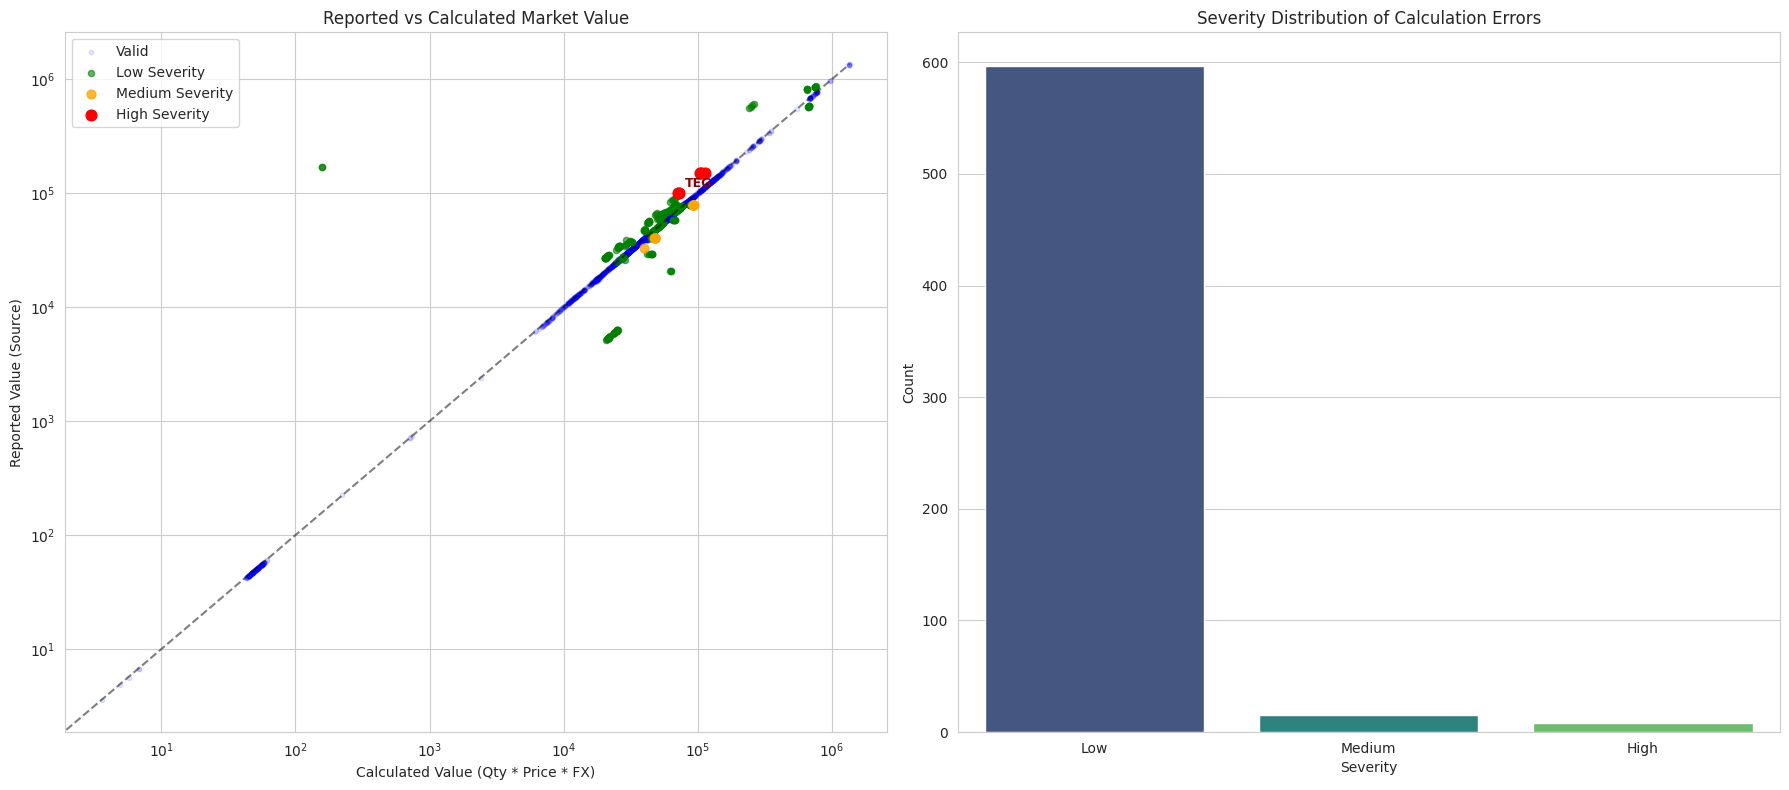

,date,ticker,error_type,description,severity
0,2022-01-03,ANTO,Calculation Error,Value Mismatch: Reported -30773.39 vs Calc -22...,Low
1,2022-01-04,ANTO,Calculation Error,Value Mismatch: Reported -31588.64 vs Calc -23...,Low
2,2022-01-05,ANTO,Calculation Error,Value Mismatch: Reported -31873.42 vs Calc -23...,Low
3,2022-01-06,ANTO,Calculation Error,Value Mismatch: Reported -30683.04 vs Calc -22...,Low
4,2022-01-07,ANTO,Calculation Error,Value Mismatch: Reported -31565.09 vs Calc -23...,Low


Found 8 High Severity errors across 3 tickers.
Visualizing top 3 most recurring high severity errors:
Visualizing ticker: TEG (Max Error: 29.7%, Count: 5)


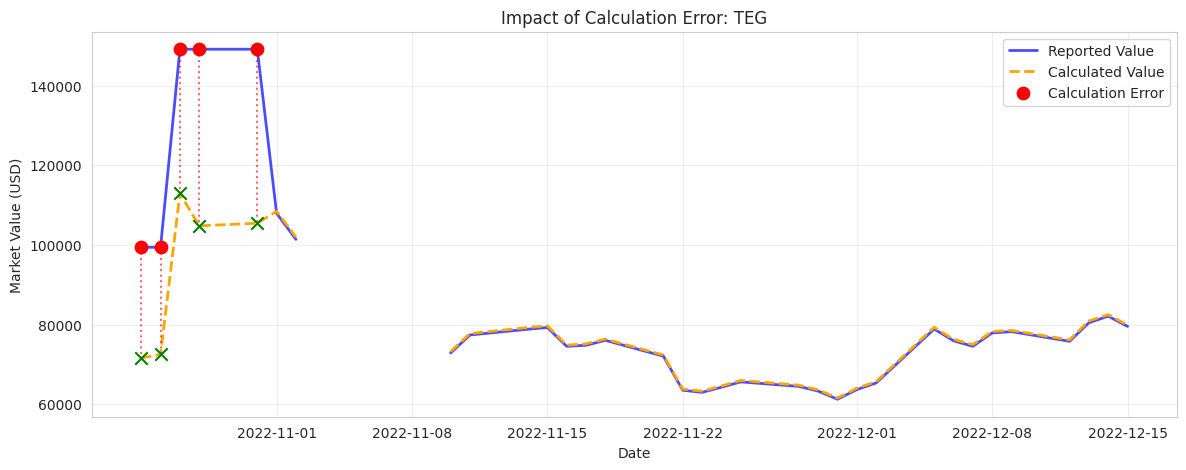

Visualizing ticker: RHM (Max Error: 178.2%, Count: 2)


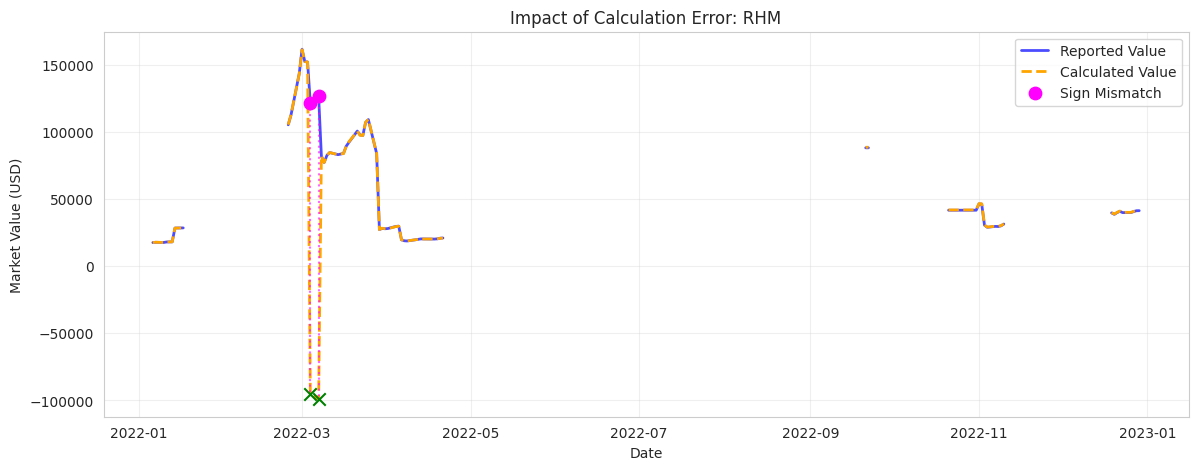

Visualizing ticker: QQQ (Max Error: 316.7%, Count: 1)


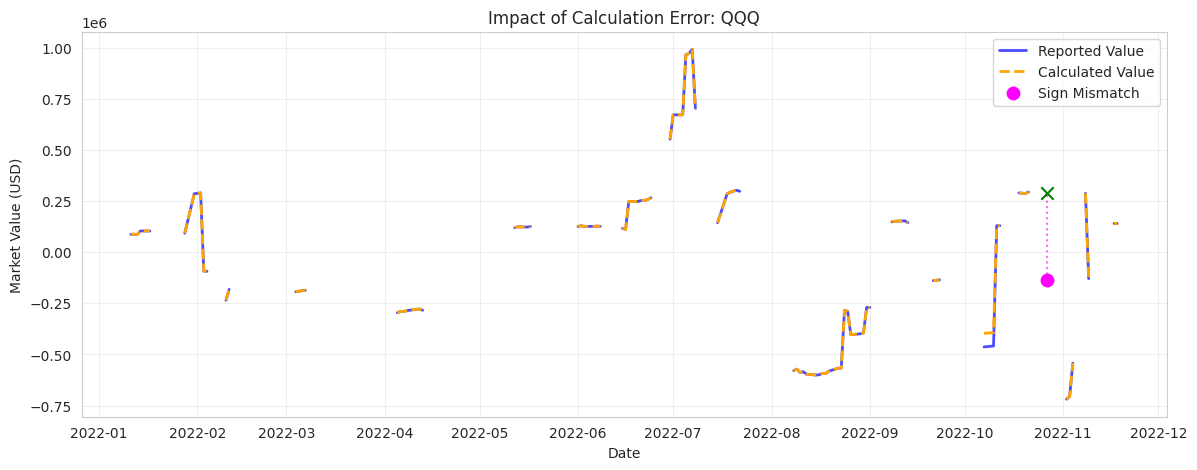

In [4]:
validator = CalculationValidator(positions, trades)
errors = validator.validate()

print(f"Found {len(errors)} calculation errors.")
if errors:
    calculation_errors_df = pd.DataFrame([vars(e) for e in errors])
    
    # Create figure with 2 subplots
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    
    # --- Subplot 1: Reported vs Calculated (Log-Log Scatter) ---
    ax1 = axes[0]
    
    # Re-calculate for plotting context
    df = positions.copy()
    cols = ["Close Quantity", "Price", "Exchange Rate", "Value in USD"]
    for col in cols:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)
        
    df["Theoretical_Value"] = df["Close Quantity"] * df["Price"] * df["Exchange Rate"]
    
    # Identify error rows
    error_keys = set((e.date, e.ticker) for e in errors)
    is_error = df.apply(lambda row: (row['Date'], row['P_Ticker']) in error_keys, axis=1)
    valid_data = df[~is_error]
    
    # Plot Valid points
    ax1.scatter(valid_data["Theoretical_Value"], valid_data["Value in USD"], 
                alpha=0.1, c='blue', label='Valid', s=10)
    
    # Plot Errors by Severity
    error_df = pd.DataFrame([vars(e) for e in errors])
    error_df['Date'] = pd.to_datetime(error_df['date'])
    error_df['P_Ticker'] = error_df['ticker']
    
    plot_errors = pd.merge(error_df, df, on=['Date', 'P_Ticker'], how='left')
    
    high = plot_errors[plot_errors['severity'] == 'High']
    med = plot_errors[plot_errors['severity'] == 'Medium']
    low = plot_errors[plot_errors['severity'] == 'Low']
    
    if not low.empty:
        ax1.scatter(low["Theoretical_Value"], low["Value in USD"], c='green', label='Low Severity', s=20, alpha=0.6)
    if not med.empty:
        ax1.scatter(med["Theoretical_Value"], med["Value in USD"], c='orange', label='Medium Severity', s=40, alpha=0.8)
    if not high.empty:
        ax1.scatter(high["Theoretical_Value"], high["Value in USD"], c='red', label='High Severity', s=60, alpha=1.0)
    
    # Annotate High Severity Errors
    annotated_tickers = set()
    for idx, row in high.iterrows():
        if row['P_Ticker'] not in annotated_tickers:
            ax1.annotate(f"{row['P_Ticker']}", 
                         (row['Theoretical_Value'], row['Value in USD']),
                         xytext=(5, 5), textcoords='offset points',
                         fontsize=9, color='darkred', fontweight='bold')
            annotated_tickers.add(row['P_Ticker'])
            if len(annotated_tickers) >= 10: break

    # Diagonal line
    max_val = max(df["Theoretical_Value"].max(), df["Value in USD"].max())
    ax1.plot([0, max_val], [0, max_val], 'k--', alpha=0.5)
    
    ax1.set_title("Reported vs Calculated Market Value")
    ax1.set_xlabel("Calculated Value (Qty * Price * FX)")
    ax1.set_ylabel("Reported Value (Source)")
    ax1.legend()
    ax1.grid(True)
    ax1.set_xscale('log')
    ax1.set_yscale('log')

    # --- Subplot 2: Severity Distribution ---
    ax2 = axes[1]
    severity_counts = calculation_errors_df['severity'].value_counts()
    sns.barplot(x=severity_counts.index, y=severity_counts.values, palette='viridis', ax=ax2)
    ax2.set_title("Severity Distribution of Calculation Errors")
    ax2.set_xlabel("Severity")
    ax2.set_ylabel("Count")
    
    plt.tight_layout()
    plt.show()
    
    display(calculation_errors_df.head())

else:
    calculation_errors_df = pd.DataFrame()

# --- Time Series Impact Analysis ---
if errors:
    # Helper to clean and parse floats
    def clean_float(x):
        try:
            return float(str(x).replace(',', '').replace(' ', ''))
        except:
            return 0.0

    def visualize_ticker_error(ticker, error_list, positions_df):
        # Filter errors for this ticker
        ticker_errors = [e for e in error_list if e.ticker == ticker]
        if not ticker_errors:
            return

        # Find the max error for title
        max_pct_error = 0
        for e in ticker_errors:
             mask = (positions_df['Date'] == e.date) & (positions_df['P_Ticker'] == e.ticker)
             if not mask.any(): continue
             row = positions_df[mask].iloc[0]
             val_usd = clean_float(row['Value in USD'])
             qty = clean_float(row['Close Quantity'])
             price = clean_float(row['Price'])
             fx = clean_float(row['Exchange Rate'])
             calc_val = qty * price * fx
             
             if val_usd != 0:
                pct = abs(val_usd - calc_val) / abs(val_usd)
             else:
                pct = 0
             if pct > max_pct_error:
                max_pct_error = pct

        print(f"Visualizing ticker: {ticker} (Max Error: {max_pct_error:.1%}, Count: {len(ticker_errors)})")
        
        # Prepare data for plotting
        ticker_df = positions_df[positions_df['P_Ticker'] == ticker].copy()
        ticker_df['Date'] = pd.to_datetime(ticker_df['Date'])
        ticker_df = ticker_df.sort_values('Date')
        
        ticker_df['Reported'] = ticker_df['Value in USD'].apply(clean_float)
        ticker_df['Qty'] = ticker_df['Close Quantity'].apply(clean_float)
        ticker_df['Px'] = ticker_df['Price'].apply(clean_float)
        ticker_df['Fx'] = ticker_df['Exchange Rate'].apply(clean_float)
        ticker_df['Calculated'] = ticker_df['Qty'] * ticker_df['Px'] * ticker_df['Fx']
        
        # Plot
        plt.figure(figsize=(14, 5))
        
        plt.plot(ticker_df['Date'], ticker_df['Reported'], label='Reported Value', color='blue', linewidth=2, alpha=0.7)
        plt.plot(ticker_df['Date'], ticker_df['Calculated'], label='Calculated Value', color='orange', linestyle='--', linewidth=2)
        
        # Highlight ALL error points
        error_dates = [e.date for e in ticker_errors]
        error_points = ticker_df[ticker_df['Date'].isin(error_dates)]
        
        if not error_points.empty:
            # Check error types
            is_sign_mismatch = any("Sign Mismatch" in e.description for e in ticker_errors)
            
            if is_sign_mismatch:
                color = 'magenta'
                label = 'Sign Mismatch'
            else:
                color = 'red'
                label = 'Calculation Error'
            
            plt.scatter(error_points['Date'], error_points['Reported'], color=color, s=80, zorder=5, label=label)
            plt.scatter(error_points['Date'], error_points['Calculated'], color='green', s=80, zorder=5, marker='x')
            
            # Draw lines for each error
            for _, row in error_points.iterrows():
                x_val = row['Date']
                y_rep = row['Reported']
                y_calc = row['Calculated']
                plt.plot([x_val, x_val], [y_rep, y_calc], color=color, linestyle=':', linewidth=1.5, alpha=0.6)

        plt.title(f"Impact of Calculation Error: {ticker}")
        plt.xlabel("Date")
        plt.ylabel("Market Value (USD)")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

    # Filter for High Severity errors
    high_severity_errors = [e for e in errors if e.severity == 'High']
    
    if high_severity_errors:
        # Count recurrence by ticker
        ticker_counts = {}
        for e in high_severity_errors:
            ticker_counts[e.ticker] = ticker_counts.get(e.ticker, 0) + 1
            
        # Sort by recurrence (most frequent first)
        sorted_tickers = sorted(ticker_counts.items(), key=lambda x: x[1], reverse=True)
        
        # Take top 10
        top_tickers = [t[0] for t in sorted_tickers[:10]]
        
        print(f"Found {len(high_severity_errors)} High Severity errors across {len(ticker_counts)} tickers.")
        print(f"Visualizing top {len(top_tickers)} most recurring high severity errors:")
        
        for ticker in top_tickers:
            visualize_ticker_error(ticker, high_severity_errors, positions)
            
    else:
        print("No High Severity errors found.")

### Systematic Discrepancy Analysis
We have identified that some tickers have consistent, systematic discrepancies (e.g., missing a constant multiplier or currency conversion). These have been downgraded to "Low" severity to separate them from genuine data glitches.

Below, we visualize these systematic errors to confirm they follow the same trend as the reported value, just offset by a factor.

Found 385 Systematic errors across 21 tickers.
Top systematic issues: ['PLUS', 'ANTO', '2GB', '2561', 'TGA']

Visualizing Systematic Error: PLUS


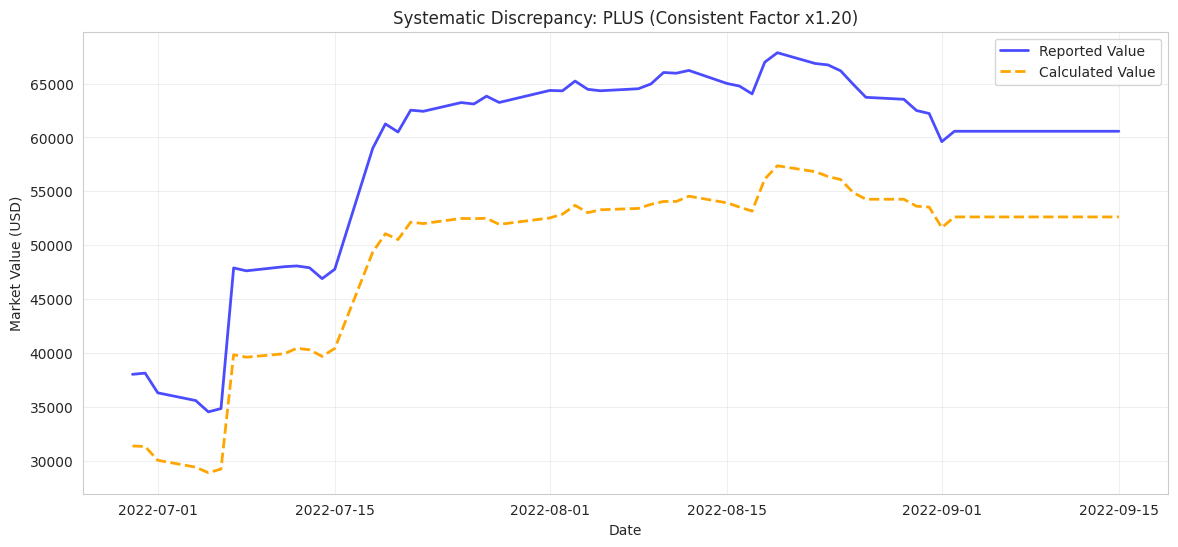

In [5]:
# Filter for Systematic Errors
systematic_errors = [e for e in errors if "Systematic Multiplier" in e.description]

if systematic_errors:
    # Count recurrence
    sys_counts = {}
    for e in systematic_errors:
        sys_counts[e.ticker] = sys_counts.get(e.ticker, 0) + 1
        
    sorted_sys = sorted(sys_counts.items(), key=lambda x: x[1], reverse=True)
    top_sys = [t[0] for t in sorted_sys[:5]]
    
    print(f"Found {len(systematic_errors)} Systematic errors across {len(sys_counts)} tickers.")
    print(f"Top systematic issues: {top_sys}")
    
    # Visualize the first one to show the "Parallel Trend"
    if top_sys:
        example_ticker = top_sys[0]
        print(f"\nVisualizing Systematic Error: {example_ticker}")
        
        # Reuse the visualization function
        # We need to define it if it wasn't defined in the previous cell (it was defined inside the if block)
        # So let's redefine/extract it or just copy logic for safety
        
        ticker_df = positions[positions['P_Ticker'] == example_ticker].copy()
        ticker_df['Date'] = pd.to_datetime(ticker_df['Date'])
        ticker_df = ticker_df.sort_values('Date')
        
        def clean_float(x):
            try:
                return float(str(x).replace(',', '').replace(' ', ''))
            except:
                return 0.0

        ticker_df['Reported'] = ticker_df['Value in USD'].apply(clean_float)
        ticker_df['Qty'] = ticker_df['Close Quantity'].apply(clean_float)
        ticker_df['Px'] = ticker_df['Price'].apply(clean_float)
        ticker_df['Fx'] = ticker_df['Exchange Rate'].apply(clean_float)
        ticker_df['Calculated'] = ticker_df['Qty'] * ticker_df['Px'] * ticker_df['Fx']
        
        plt.figure(figsize=(14, 6))
        plt.plot(ticker_df['Date'], ticker_df['Reported'], label='Reported Value', color='blue', linewidth=2, alpha=0.7)
        plt.plot(ticker_df['Date'], ticker_df['Calculated'], label='Calculated Value', color='orange', linestyle='--', linewidth=2)
        
        # Extract multiplier from description of the first error for this ticker
        example_error = next(e for e in systematic_errors if e.ticker == example_ticker)
        import re
        match = re.search(r"x([\d\.]+)", example_error.description)
        mult = match.group(1) if match else "?"
        
        plt.title(f"Systematic Discrepancy: {example_ticker} (Consistent Factor x{mult})")
        plt.xlabel("Date")
        plt.ylabel("Market Value (USD)")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
else:
    print("No Systematic errors found.")

## 4. Consistency Validation

This section checks for consistency between the **Trade Price** (execution price) and the **Market Price** (reported closing price) for the same day. Significant deviations are flagged as potential errors.

Found 27 consistency errors.


/tmp/ipykernel_213209/1042476551.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=severity_counts.index, y=severity_counts.values, palette='viridis', ax=ax2)


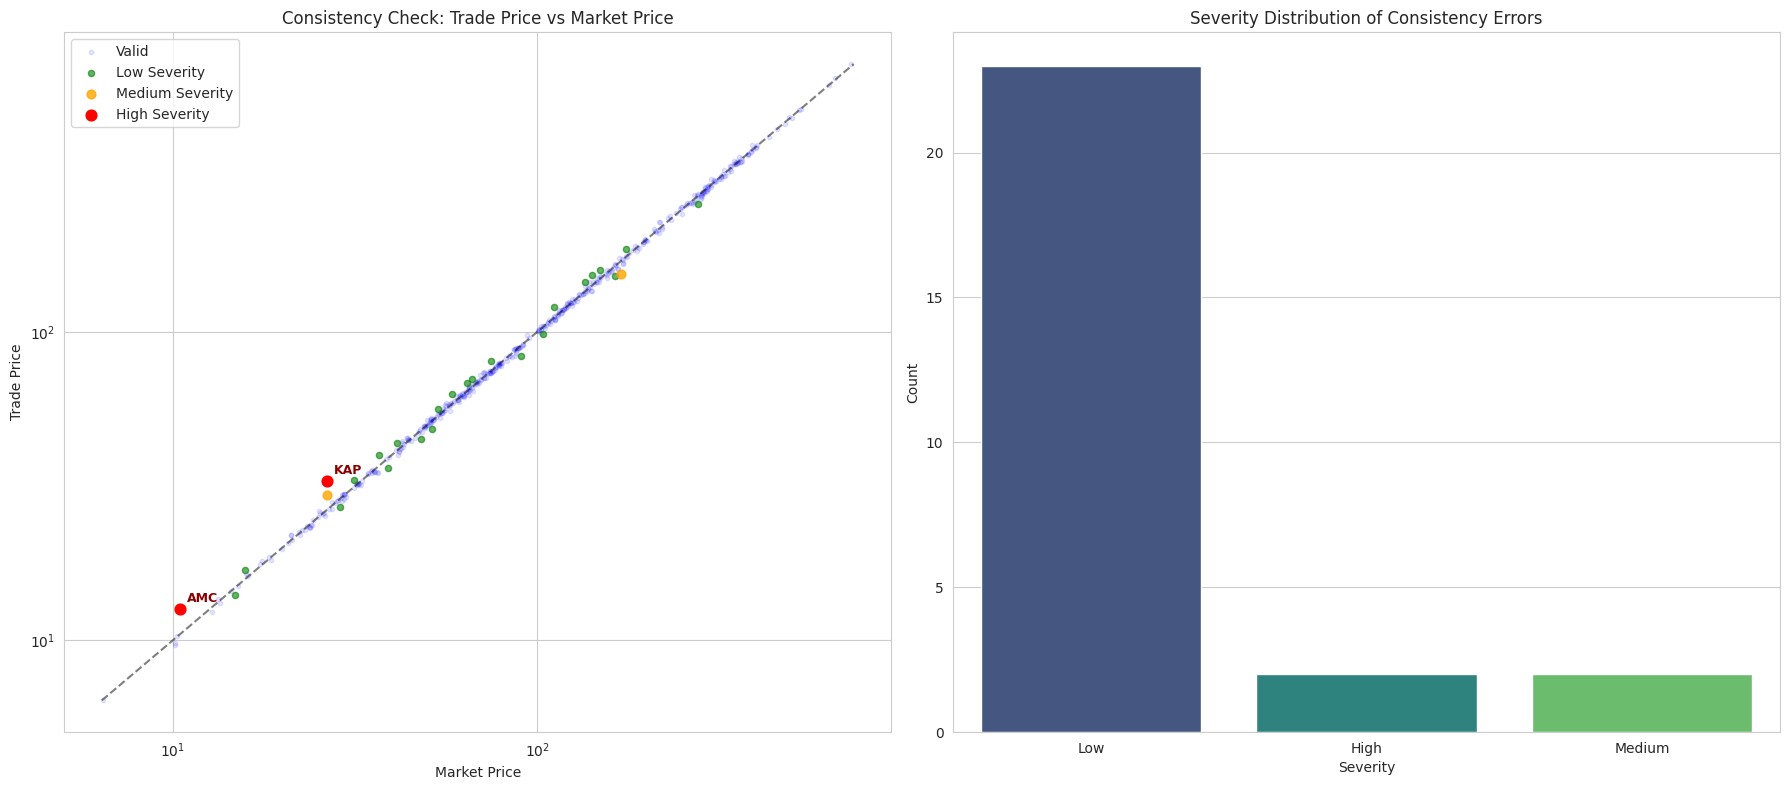

Visualizing 2 tickers with High Severity consistency errors.
Visualizing consistency errors for: AMC (Count: 1)


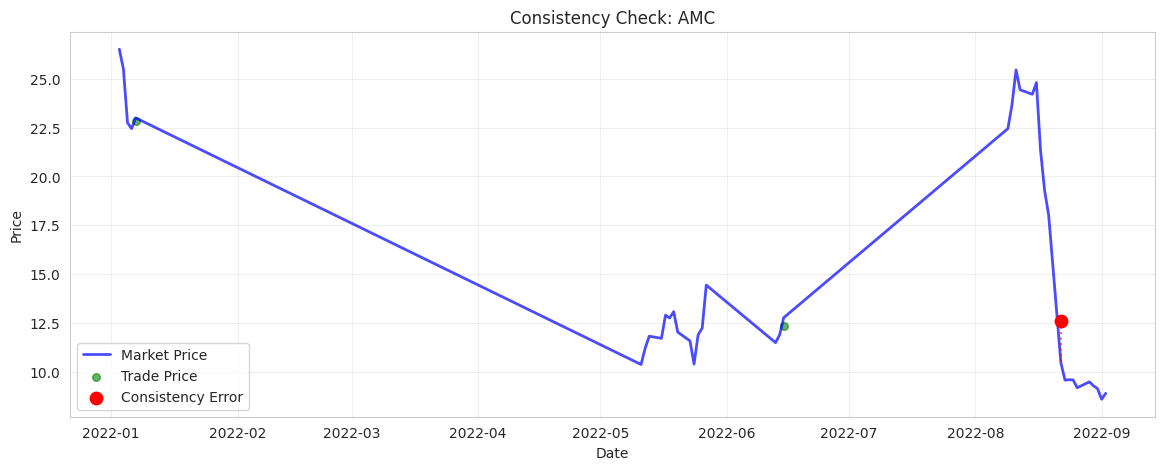

Visualizing consistency errors for: KAP (Count: 1)


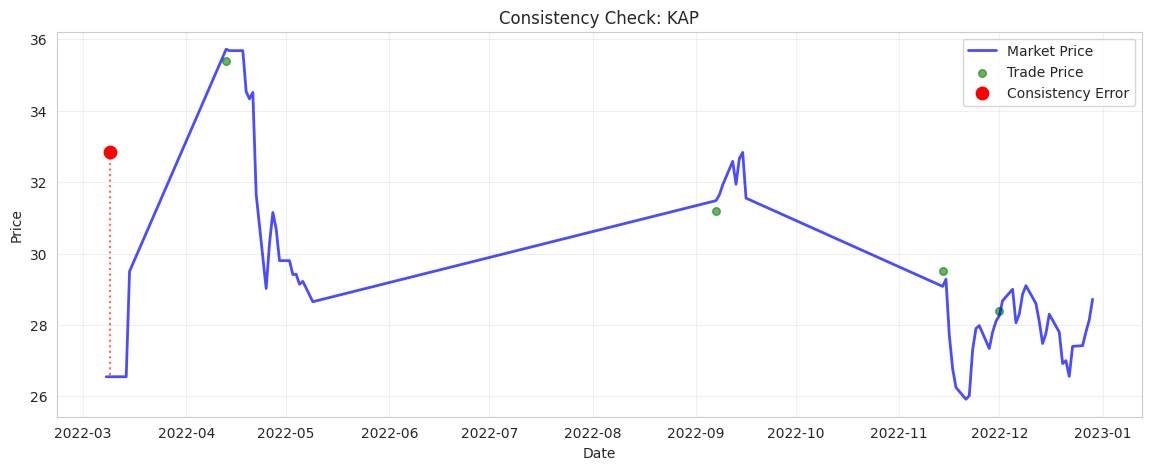

In [6]:
validator = ConsistencyValidator(positions, trades)
consistency_errors = validator.validate()

print(f"Found {len(consistency_errors)} consistency errors.")
if consistency_errors:
    consistency_errors_df = pd.DataFrame([vars(e) for e in consistency_errors])
    
    # Create figure with 2 subplots
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    
    # --- Subplot 1: Trade Price vs Market Price (Scatter) ---
    ax1 = axes[0]
    
    # Prepare data for plotting
    df = positions.copy()
    cols = ["Price", "Trade Price", "Traded Today"]
    for col in cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        
    # Filter for days with trades
    df = df[df["Traded Today"].abs() > 0].copy()
    df = df.dropna(subset=["Price", "Trade Price"])
    
    # Identify error rows
    error_keys = set((e.date, e.ticker) for e in consistency_errors)
    severity_map = {(e.date, e.ticker): e.severity for e in consistency_errors}
    
    df['Is_Error'] = df.apply(lambda row: (row['Date'], row['P_Ticker']) in error_keys, axis=1)
    df['Severity'] = df.apply(lambda row: severity_map.get((row['Date'], row['P_Ticker']), 'None'), axis=1)
    
    # Plot Valid points
    valid_data = df[~df['Is_Error']]
    ax1.scatter(valid_data["Price"], valid_data["Trade Price"], 
                alpha=0.1, c='blue', label='Valid', s=10)
    
    # Plot Errors by Severity
    high = df[df['Severity'] == 'High']
    med = df[df['Severity'] == 'Medium']
    low = df[df['Severity'] == 'Low']
    
    if not low.empty:
        ax1.scatter(low["Price"], low["Trade Price"], c='green', label='Low Severity', s=20, alpha=0.6)
    if not med.empty:
        ax1.scatter(med["Price"], med["Trade Price"], c='orange', label='Medium Severity', s=40, alpha=0.8)
    if not high.empty:
        ax1.scatter(high["Price"], high["Trade Price"], c='red', label='High Severity', s=60, alpha=1.0)
    
    # Annotate High Severity Errors
    annotated_tickers = set()
    for idx, row in high.iterrows():
        if row['P_Ticker'] not in annotated_tickers:
            ax1.annotate(f"{row['P_Ticker']}", 
                         (row['Price'], row['Trade Price']),
                         xytext=(5, 5), textcoords='offset points',
                         fontsize=9, color='darkred', fontweight='bold')
            annotated_tickers.add(row['P_Ticker'])
            if len(annotated_tickers) >= 10: break

    # Diagonal line
    max_val = max(df["Price"].max(), df["Trade Price"].max())
    min_val = min(df["Price"].min(), df["Trade Price"].min())
    
    ax1.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5)
    
    ax1.set_title("Consistency Check: Trade Price vs Market Price")
    ax1.set_xlabel("Market Price")
    ax1.set_ylabel("Trade Price")
    ax1.legend()
    ax1.grid(True)
    
    # Use log scale if range is huge
    if max_val / (min_val + 0.01) > 100:
        ax1.set_xscale('log')
        ax1.set_yscale('log')

    # --- Subplot 2: Severity Distribution ---
    ax2 = axes[1]
    severity_counts = consistency_errors_df['severity'].value_counts()
    sns.barplot(x=severity_counts.index, y=severity_counts.values, palette='viridis', ax=ax2)
    ax2.set_title("Severity Distribution of Consistency Errors")
    ax2.set_xlabel("Severity")
    ax2.set_ylabel("Count")
    
    plt.tight_layout()
    plt.show()
    
else:
    consistency_errors_df = pd.DataFrame()

# --- Time Series Analysis for High Severity Errors ---
def visualize_ticker_consistency(ticker, error_list, positions_df):
    # Filter errors for this ticker
    ticker_errors = [e for e in error_list if e.ticker == ticker]
    if not ticker_errors:
        return

    print(f"Visualizing consistency errors for: {ticker} (Count: {len(ticker_errors)})")
    
    # Prepare data
    ticker_df = positions_df[positions_df['P_Ticker'] == ticker].copy()
    ticker_df['Date'] = pd.to_datetime(ticker_df['Date'])
    ticker_df = ticker_df.sort_values('Date')
    
    ticker_df['Price'] = pd.to_numeric(ticker_df['Price'], errors='coerce')
    ticker_df['Trade Price'] = pd.to_numeric(ticker_df['Trade Price'], errors='coerce')
    ticker_df['Traded Today'] = pd.to_numeric(ticker_df['Traded Today'], errors='coerce').fillna(0)
    
    plt.figure(figsize=(14, 5))
    
    plt.plot(ticker_df['Date'], ticker_df['Price'], label='Market Price', color='blue', linewidth=2, alpha=0.7)
    
    # Plot trades
    trades_only = ticker_df[ticker_df['Traded Today'].abs() > 0]
    plt.scatter(trades_only['Date'], trades_only['Trade Price'], label='Trade Price', color='green', marker='o', s=30, alpha=0.6)
    
    # Highlight errors
    error_dates = [e.date for e in ticker_errors]
    error_points = ticker_df[ticker_df['Date'].isin(error_dates)]
    
    if not error_points.empty:
        plt.scatter(error_points['Date'], error_points['Trade Price'], color='red', s=80, zorder=5, label='Consistency Error')
        
        # Draw vertical lines connecting Trade Price to Market Price
        for _, row in error_points.iterrows():
            plt.plot([row['Date'], row['Date']], [row['Trade Price'], row['Price']], 
                     color='red', linestyle=':', linewidth=1.5, alpha=0.6)

    plt.title(f"Consistency Check: {ticker}")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Visualize only tickers with High Severity errors
if consistency_errors:
    # Filter for High Severity
    high_severity_errors = [e for e in consistency_errors if e.severity == 'High']
    
    if high_severity_errors:
        # Get unique tickers with high severity errors
        error_tickers = list(set(e.ticker for e in high_severity_errors))
        
        print(f"Visualizing {len(error_tickers)} tickers with High Severity consistency errors.")
        for ticker in error_tickers:
            visualize_ticker_consistency(ticker, high_severity_errors, positions)
    else:
        print("No High Severity consistency errors found.")
else:
    print("No errors found.")

## 5. Data Completeness Validation

We check for missing essential data points such as Prices, Dates, and Tickers.
Missing values are flagged as **Medium** severity errors, as they impede analysis but do not necessarily indicate incorrect data, just incomplete data.

Found 584 completeness errors.


,date,ticker,error_type,description,severity
0,2022-01-04,ADBE,Missing Data,Missing value for critical column: 'Close Quan...,Medium
1,2022-01-04,ADI,Missing Data,Missing value for critical column: 'Close Quan...,Medium
2,2022-01-04,NFLX,Missing Data,Missing value for critical column: 'Close Quan...,Medium
3,2022-01-04,NUE,Missing Data,Missing value for critical column: 'Close Quan...,Medium
4,2022-01-04,PLZL,Missing Data,Missing value for critical column: 'Close Quan...,Medium


Missing Data Distribution:


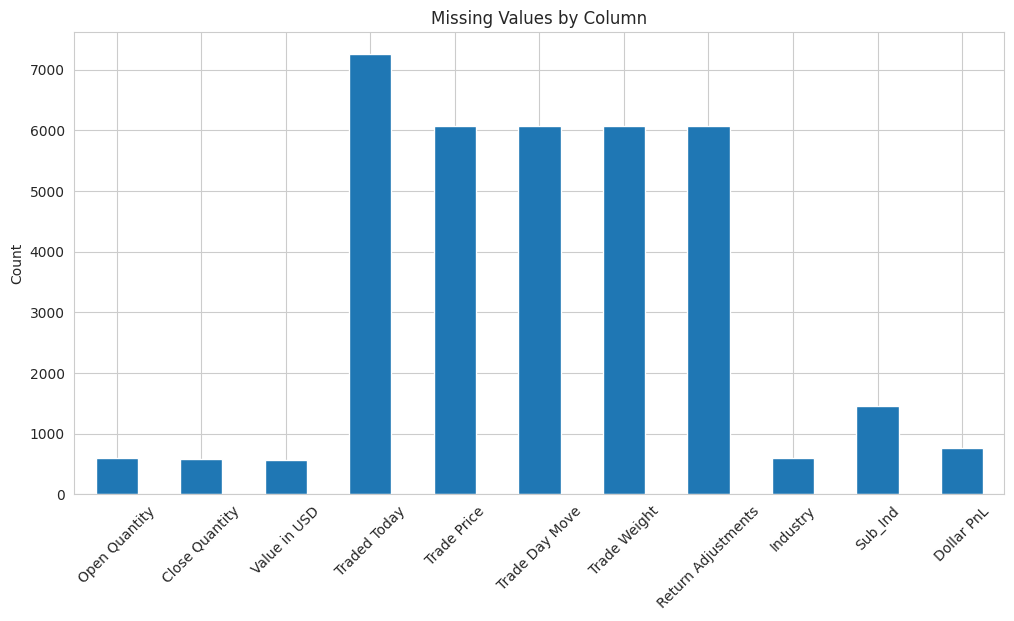

In [7]:
validator = DataCompletenessValidator(positions, trades)
completeness_errors = validator.validate()

print(f"Found {len(completeness_errors)} completeness errors.")
if completeness_errors:
    completeness_errors_df = pd.DataFrame([vars(e) for e in completeness_errors])
    display(completeness_errors_df.head())
    
    # Visualize Missing Data by Column
    print("Missing Data Distribution:")
    missing_counts = positions.isnull().sum()
    missing_counts = missing_counts[missing_counts > 0]
    
    if not missing_counts.empty:
        plt.figure(figsize=(12, 6))
        missing_counts.plot(kind='bar')
        plt.title("Missing Values by Column")
        plt.ylabel("Count")
        plt.xticks(rotation=45)
        plt.show()
else:
    completeness_errors_df = pd.DataFrame()

## 6. FX Validation

We validate that the implied exchange rates in the data match the reported exchange rates.

In [8]:
validator = FXConsistencyValidator(positions, trades)
fx_errors = validator.validate()

print(f"Found {len(fx_errors)} FX errors.")
if fx_errors:
    fx_errors_df = pd.DataFrame([vars(e) for e in fx_errors])
    display(fx_errors_df.head())
else:
    fx_errors_df = pd.DataFrame()

Found 0 FX errors.


No FX consistency errors were found.

This confirms that for all non-USD assets, the reported 'Value in USD' matches the implied calculation using the provided 'Exchange Rate'.

## 7. Static Data Validation

We check for invalid or missing static data, such as Ticker symbols and ISINs.

Found 169 static data errors.


,date,ticker,error_type,description,severity
0,2022-11-09,0486.HK,Static Data Inconsistency,Static field 'Industry' changed. Found 'No GIC...,Medium
1,2022-11-10,0486.HK,Static Data Inconsistency,Static field 'Industry' changed. Found 'No GIC...,Medium
2,2022-11-24,0486.HK,Static Data Inconsistency,Static field 'Industry' changed. Found 'No GIC...,Medium
3,2022-12-07,0486.HK,Static Data Inconsistency,Static field 'Industry' changed. Found 'No GIC...,Medium
4,2022-12-08,0486.HK,Static Data Inconsistency,Static field 'Industry' changed. Found 'No GIC...,Medium


Static Data Error Distribution:


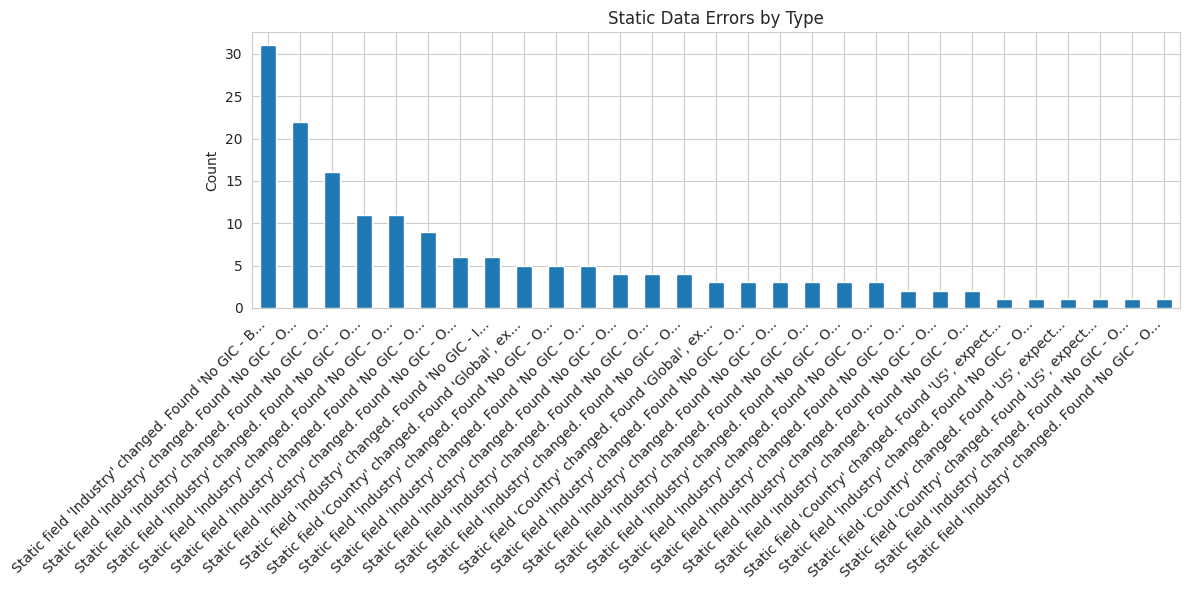

In [11]:
validator = StaticDataValidator(positions, trades)
static_errors = validator.validate()

print(f"Found {len(static_errors)} static data errors.")
if static_errors:
    static_errors_df = pd.DataFrame([vars(e) for e in static_errors])
    display(static_errors_df.head())
    
    # Visualize Static Data Errors
    print("Static Data Error Distribution:")
    # Group by error type or description to show what kind of static data issues exist
    error_counts = static_errors_df['description'].value_counts()
    
    if not error_counts.empty:
        # Truncate long descriptions for better visualization
        short_index = [desc[:50] + '...' if len(str(desc)) > 50 else str(desc) for desc in error_counts.index]
        error_counts.index = short_index  # type: ignore
        
        plt.figure(figsize=(12, 6))
        error_counts.plot(kind='bar')
        plt.title("Static Data Errors by Type")
        plt.ylabel("Count")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
else:
    static_errors_df = pd.DataFrame()
    print("No static data errors found. All tickers and ISINs appear valid according to the validation rules.")

## 8. Aggregation & Conclusion
We aggregate all findings to identify the most problematic assets and the most common error types.

Total Errors Found: 1422


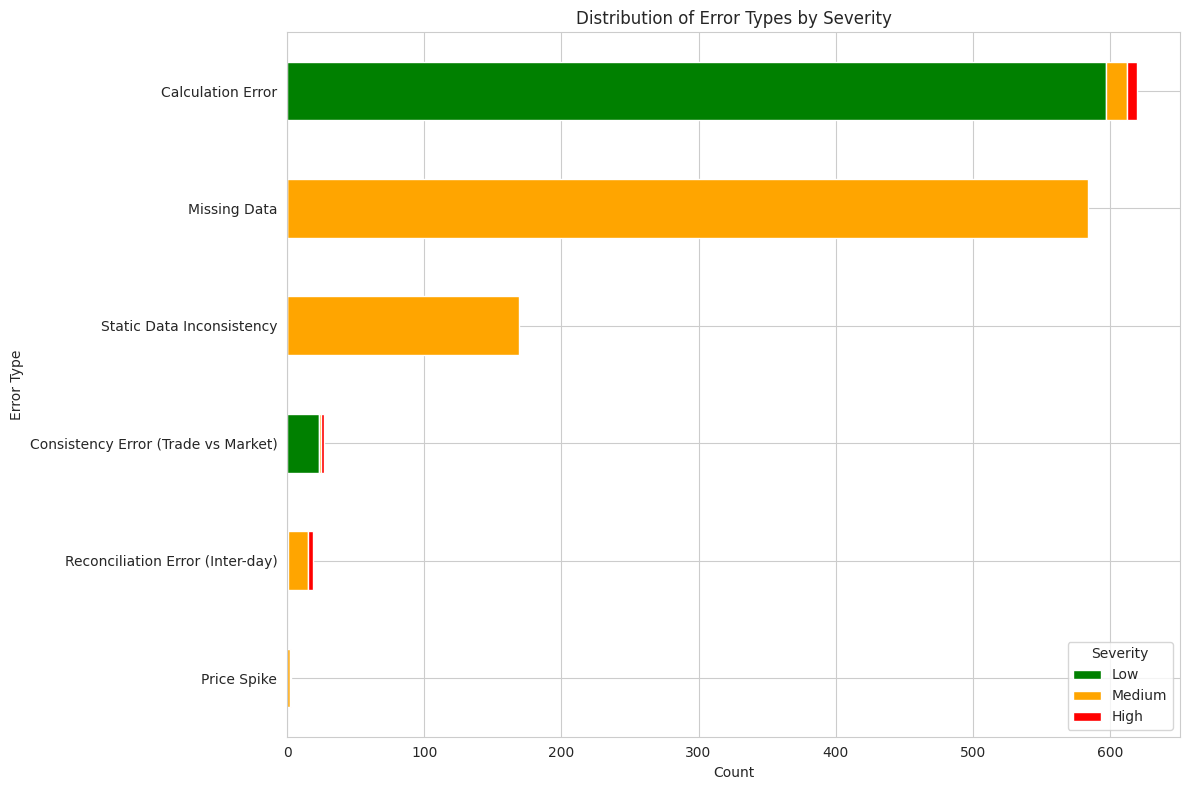


--- High Severity Errors Analysis (Action Items) ---
Found 15 High Severity Errors that require immediate attention.


/tmp/ipykernel_213209/2898813036.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=high_counts.values, y=high_counts.index, palette='Reds_r')


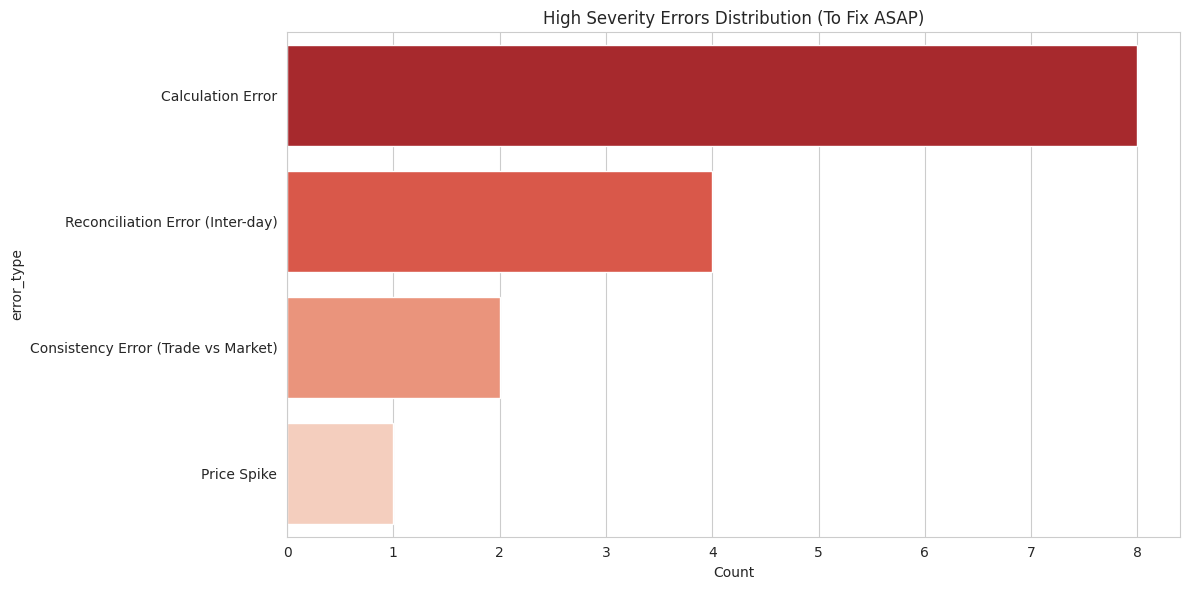

/tmp/ipykernel_213209/2898813036.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_high_tickers.values, y=top_high_tickers.index, palette='dark:red')


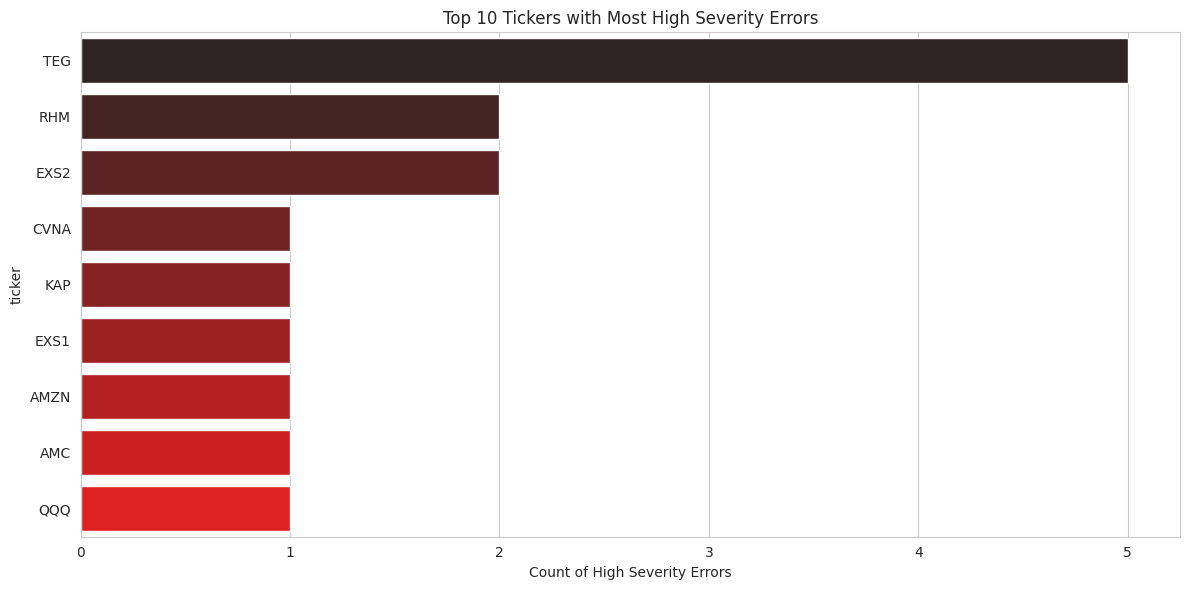

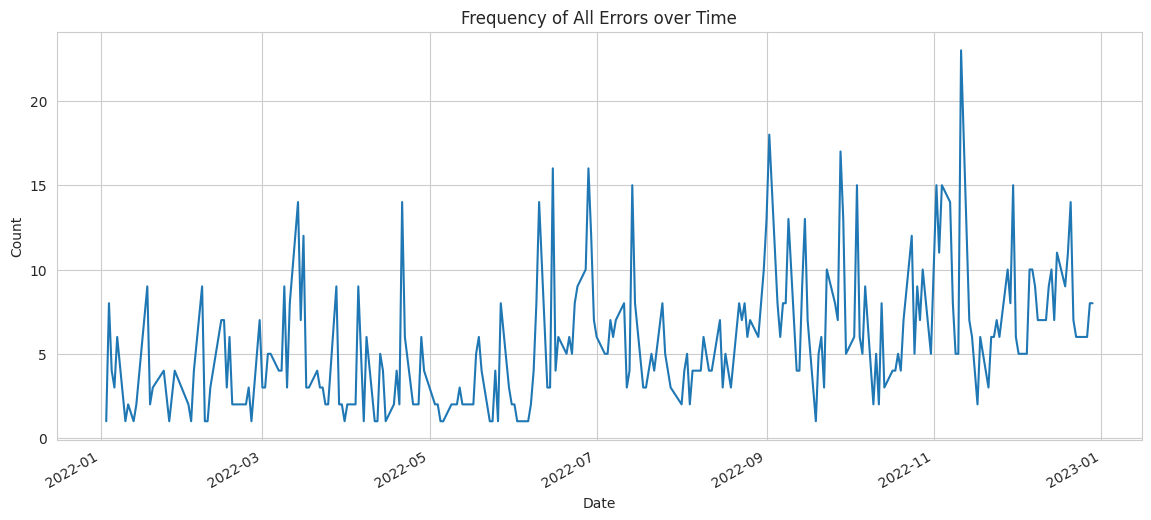


Summary of Errors by Ticker:


error_type,Calculation Error,Consistency Error (Trade vs Market),Missing Data,Price Spike,Reconciliation Error (Inter-day),Static Data Inconsistency,Total
ticker,,,,,,,
ANTO,60,0,6,0,0,3,69
XTB,64,0,1,0,0,0,65
PLUS,56,0,1,0,0,0,57
HAG,37,0,1,0,0,1,39
TGA,30,0,1,0,0,6,37
2GB,31,0,1,0,0,0,32
QQQ,3,0,27,0,2,0,32
EMHY,0,0,1,0,0,31,32
2561,30,0,1,0,0,0,31


In [12]:
# Aggregate all errors
all_errors_dfs = [
    completeness_errors_df,
    static_errors_df,
    price_errors_df,
    fx_errors_df,
    consistency_errors_df,
    reconciliation_errors_df,
    calculation_errors_df
]

# Filter out empty DataFrames
all_errors_dfs = [df for df in all_errors_dfs if not df.empty]

if all_errors_dfs:
    master_df = pd.concat(all_errors_dfs, ignore_index=True)
    print(f"Total Errors Found: {len(master_df)}")
    
    # --- 1. Error Types with Severity Breakdown (Stacked Bar Chart) ---
    # Group by Error Type and Severity
    severity_breakdown = master_df.groupby(['error_type', 'severity']).size().unstack(fill_value=0)
    
    # Reorder columns to ensure logical progression: Low -> Medium -> High
    desired_order = ['Low', 'Medium', 'High']
    cols = [c for c in desired_order if c in severity_breakdown.columns]
    severity_breakdown = severity_breakdown[cols]
    
    # Sort by total count for better visualization
    severity_breakdown['Total'] = severity_breakdown.sum(axis=1)
    severity_breakdown = severity_breakdown.sort_values('Total', ascending=True)
    severity_breakdown = severity_breakdown.drop(columns=['Total'])
    
    # Plot Stacked Bar Chart
    ax = severity_breakdown.plot(kind='barh', stacked=True, color=['green', 'orange', 'red'], figsize=(12, 8))
    plt.title("Distribution of Error Types by Severity")
    plt.xlabel("Count")
    plt.ylabel("Error Type")
    plt.legend(title='Severity', loc='lower right')
    plt.tight_layout()
    plt.show()
    
    # --- 2. Focus on High Severity Errors ---
    high_severity = master_df[master_df['severity'] == 'High']
    
    if not high_severity.empty:
        print(f"\n--- High Severity Errors Analysis (Action Items) ---")
        print(f"Found {len(high_severity)} High Severity Errors that require immediate attention.")
        
        # Distribution of High Severity Errors by Type
        high_counts = high_severity['error_type'].value_counts()
        
        plt.figure(figsize=(12, 6))
        sns.barplot(x=high_counts.values, y=high_counts.index, palette='Reds_r')
        plt.title("High Severity Errors Distribution (To Fix ASAP)")
        plt.xlabel("Count")
        plt.tight_layout()
        plt.show()
        
        # Top Tickers with High Severity Errors
        top_high_tickers = high_severity['ticker'].value_counts().head(10)
        
        plt.figure(figsize=(12, 6))
        sns.barplot(x=top_high_tickers.values, y=top_high_tickers.index, palette='dark:red')
        plt.title("Top 10 Tickers with Most High Severity Errors")
        plt.xlabel("Count of High Severity Errors")
        plt.tight_layout()
        plt.show()
    else:
        print("No High Severity errors found.")
    
    # --- 3. Errors over Time ---
    master_df['Date'] = pd.to_datetime(master_df['date'])
    errors_by_date = master_df.groupby('Date').size()
    
    plt.figure(figsize=(14, 6))
    errors_by_date.plot()
    plt.title("Frequency of All Errors over Time")
    plt.ylabel("Count")
    plt.show()
    
    # Display Summary Table
    print("\nSummary of Errors by Ticker:")
    summary = master_df.groupby(['ticker', 'error_type']).size().unstack(fill_value=0)
    summary['Total'] = summary.sum(axis=1)
    display(summary.sort_values('Total', ascending=False).head(10))
else:
    print("No errors found across all validators.")